In [1]:
import LOM

## Steps:
Generate three types of process through kernels:
- Gaussian -1
- Increasing/Decreasing linear trend
- Gaussian -2
- Generate latent process and a random phi add noise
- Label processes as coming from increasing trend-G1 as 1’s and decreasing trend-G1/G2 as 0’s
- Increasing N, check classification accuracy 
- Increasing  n, check classification accuracy
- Compare with Logistic regression and LDA: Stretch goal


In [122]:
## Linear increasing kernel
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
kenrel = GPy.kern.Linear(1,variances=3)  * GPy.kern.Brownian(1,variance=2) 
print kenrel
N = 100
S =100
P = 3
C = 5
s2 = 1
x = np.linspace(0,N-1,N)
kenrel = GPy.kern.Linear(1,variances=3) * GPy.kern.Brownian(1,variance=3) + GPy.kern.Matern52(1,variance=2,lengthscale=3) 
Matern1 = GPy.kern.PeriodicMatern32(1,lengthscale=3,variance=2)
Cosine1 = GPy.kern.Cosine(1,lengthscale=3,variance=2)
gaussian = GPy.kern.ExpQuad(1,lengthscale=3,variance=2)

  mul.               |  value  |  constraints  |  priors
  linear.variances   |    3.0  |      +ve      |        
  Brownian.variance  |    2.0  |      +ve      |        


In [48]:
def scale(d):
    return (d - d.min())/(d.max() - d.min())

def generatelatent(N,noiselevel=0.5):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    u2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g1 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Matern1.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g2 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Cosine1.K(x.reshape(N,1))) + noiselevel*np.random.normal(0,1,N)
    return scale(u1),scale(u2),scale(g1),scale(g2)


Now we know our latent processes: g1,g2,increasingTrend,decreasingTrend
We sample phi and then combine these to generate data such that:
    - with probability 0.5:
        get g1 and increasing trend set Label to 1
     - With probability 0.5:
         get g1 or g2 with equal probability combine with decreasing trend and set label to -1
        

In [43]:
def generateData(latents,S=100,split=0.5,noise = 1):
    P = len(latents)-1
    N = latents[0].shape[0]
    phi = np.random.normal(loc=0,scale=1,size=(C,P))
    B = np.ones(S)
    W = np.random.rand(P*N)
    uBar = np.matrix(np.ones((S,N*P)))
    phiBar = np.matrix(np.kron(phi,np.eye(N)))
    l = np.zeros(S)
    L = np.zeros(S)
    for s in range(S):
        if np.random.rand() < 0.4:
            L[s] = 1
            us = np.hstack([a for i,a in enumerate(latents) if i!=1 ])
        else:
            L[s] = -1
            us = np.hstack([a for i,a in enumerate(latents) if i!=0 ])
            
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    #L[s] = guessLabel(l[s])
    YBar = uBar * phiBar.T + np.random.normal(0,noise)
    return YBar, L ,uBar 

In [44]:
l = list(generatelatent(20))
data,labels,latents = generateData(l)

 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


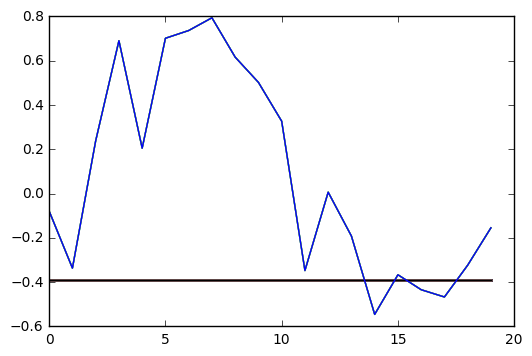

(100,) (100,) (100,) (100,)


 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning:covariance is not positive-semidefinite.
 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


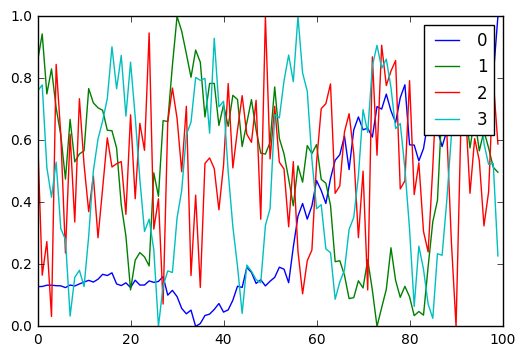

In [123]:
latent = generatelatent(N)
for i,l in enumerate(latent):
    plt.plot(l,label=i)
plt.legend()
decreasingTrend = latent[0]
g1 = latent[2]
g2= latent[3]
increasingTrend = latent[1]
print increasingTrend.shape,decreasingTrend.shape,g1.shape,g2.shape


Phi
[[-1.25299423  0.45526353]
 [-0.25115143  0.63638353]
 [ 0.40348482 -0.87795368]
 [-0.97081465  0.13328934]
 [-1.32638192  0.38058035]]


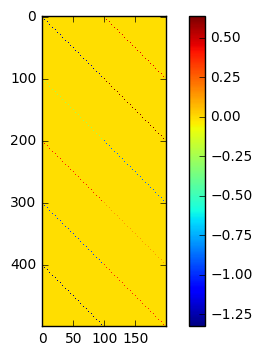

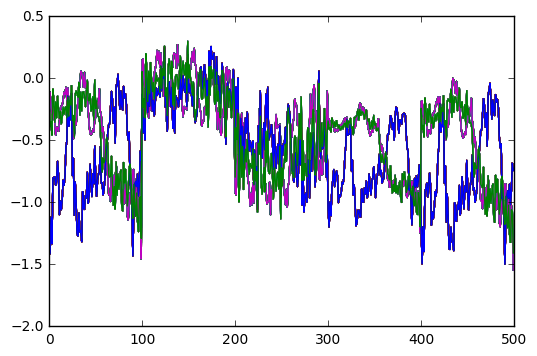

In [124]:
P=2
phi = np.random.normal(loc=0,scale=1,size=(C,P))
phiBar = np.matrix(np.kron(phi,np.eye(N)))
print "Phi\n",phi
plt.imshow(phiBar,interpolation='none')
plt.colorbar()
plt.show()
def guessLabel(l,mu=0):
    if l < mu:
        return -1
    else:
        return 1

B = np.ones(S)
W = np.random.rand(P*N)
uBar = np.matrix(np.ones((S,N*P)))
l = np.zeros(S)
L = np.zeros(S)
for s in range(S):
    if np.random.rand() < 0.4:
        L[s] = 1
        us = np.hstack([increasingTrend,g1])
    else:
        L[s] = -1
        if np.random.rand() < 0.5:
            us = np.hstack([decreasingTrend,g1])
        else:
            us = np.hstack([decreasingTrend,g2])
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    #L[s] = guessLabel(l[s])
YBar = uBar * phiBar.T + np.random.normal(0,s2)
i=plt.plot(YBar.T)

In [125]:
C

5

In [126]:
from sklearn.cross_validation import train_test_split
Y_train, Y_test, L_train, L_test = train_test_split(YBar, L, test_size=0.4, random_state=0)

(array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

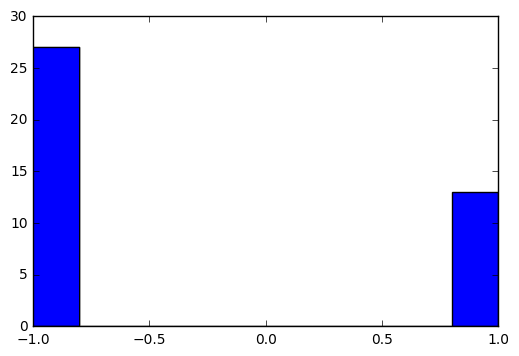

In [127]:
plt.hist(L_test)

### training

Concatenated Latent Gaussian Processes:
(500, 500) (500, 500) 0 15 30 45 60 75 90 105 120 135


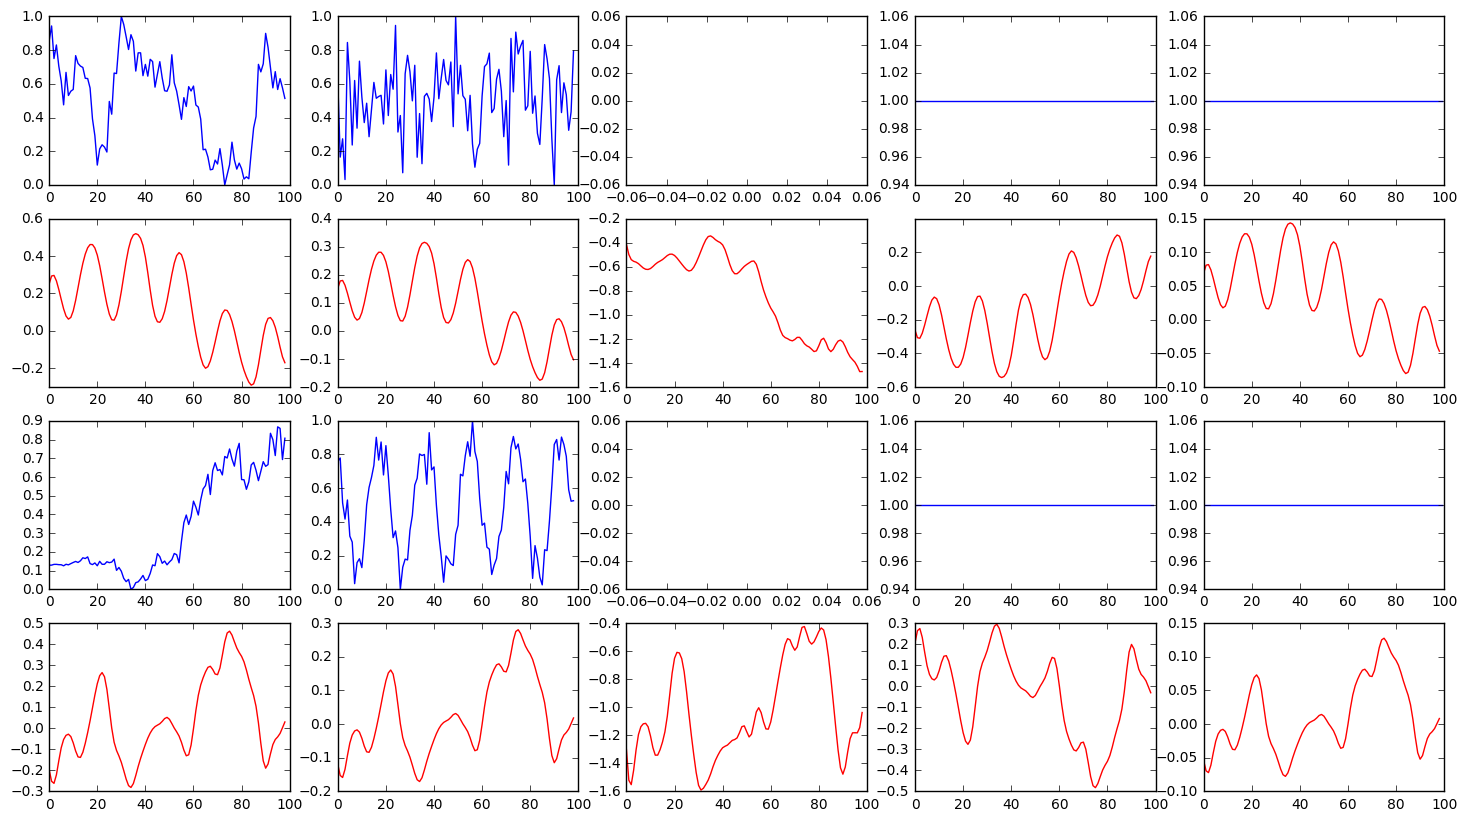

In [128]:
#uBar = latents
myModel = LOM.LOM(Y=Y_train,L=L_train,N=N,C=C,S=L_train.shape[0])
myModel.fit(n=int(N),iters=150,P=5)
plt.show()
fig,axes = plt.subplots(nrows=2*2,ncols=myModel.P,figsize=(18,10))
for s in range(2):
    for p in range(myModel.P):
        if p <= uBar.shape[1]/N:
            axes[2*s+0,p].plot(uBar[s,p*N:p*N+N-1].T)
        else:
            axes[2*s+0,p].plot(np.ones(N).T)
        axes[2*s+1,p].plot(myModel.uExpBar[s+3,p*N:p*N+N-1].T,c='r')

In [110]:
import pickle

In [133]:
f = open("YBar.pickle","wb")
pickle.dump(YBar,f)
f.close()
f = open("Labels.data","wb")
pickle.dump(L,f)
f.close()


In [120]:
import pickle
YBar = pickle.load(open("YBar.data","rb"))
L = pickle.load(open("Labels.data","rb"))
Y_train, Y_test, L_train, L_test = train_test_split(YBar, L, test_size=0.4, random_state=0)
myModel = LOM.LOM(Y=Y_train,L=L_train,N=N,C=C,S=L_train.shape[0])
myModel.fit(n=int(60*1),iters=200,P=3)
predictions,Expresults, _ = myModel.predict(Y_test)
print "Result:",np.unique(predictions,return_counts=True),np.unique(L_test,return_counts=True)

Concatenated Latent Gaussian Processes:
(180, 180) (180, 180) 0 20 40 60 80 100 120 140 160 180 Result: (array([-1.,  1.]), array([17, 23])) (array([-1.,  1.]), array([17, 23]))


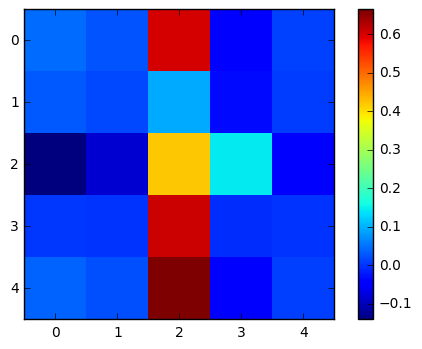

In [129]:
plt.imshow(myModel.phiHatExp,interpolation='None')
plt.colorbar()

## Prediction

In [130]:
results,Expresults, _ = myModel.predict(Y_test)

In [131]:
results

array([ 1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.])

In [132]:
L_test

array([ 1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.])

In [109]:
#acc = results ==L_test
#acc.mean()
np.mean(results ==L_test)

1.0

In [283]:
from sklearn.metrics import accuracy_score
accuracy_score(results,L_test)

1.0

### testing Infra:

## Testing the effect of inducing points 

 
---
 induction level: 1.0
Concatenated Latent Gaussian Processes:
(600, 600) (600, 600) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 600) (600, 600) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 600) (600, 600) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 600) (600, 600) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 600) (600, 600) 0 15 30 45 60 75 90 105 120 135 
---
 induction level: 0.9
Concatenated Latent Gaussian Processes:
(600, 540) (540, 540) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 540) (540, 540) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 540) (540, 540) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 540) (540, 540) 0 15 30 45 60 75 90 105 120 135 Concatenated Latent Gaussian Processes:
(600, 540) (540, 540) 0 15 30 45 60 75 90 105 120 135 
---


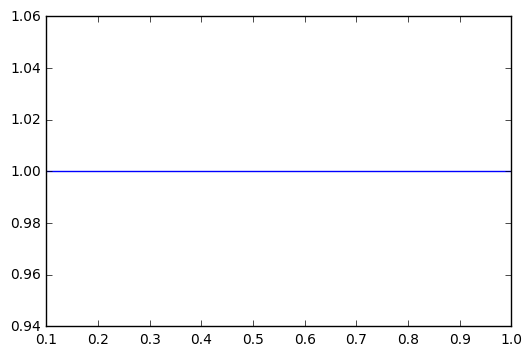

In [289]:
induction = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
results = []
for ind in induction:
    accuracies = []
    print "\n---\n induction level:",ind
    for times in range(5):
        # create train test split
        Y_train, Y_test, L_train, L_test = train_test_split(YBar, L, test_size=0.4, random_state=0)
        # fit the model
        myModel = LOM.LOM(Y=Y_train,L=L_train,N=N,C=C,S=L_train.shape[0])
        myModel.fit(n=int(N*ind),iters=150,P=3)
        # predict for test
        predictions,Expresults, _ = myModel.predict(Y_test)
        # calcualte accuracy
        accuracies.append(accuracy_score(predictions,L_test))
    avgAccuracy = np.mean(accuracies)
    results.append(avgAccuracy)
plt.plot(induction,results)

In [319]:
### testing Infra:
a,b,c,d = getData()
## Testing the effect of no of Trials

 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning:covariance is not positive-semidefinite.
 /m/home/home8/81/nautiys1/unix/jupyter/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning:covariance is not positive-semidefinite.


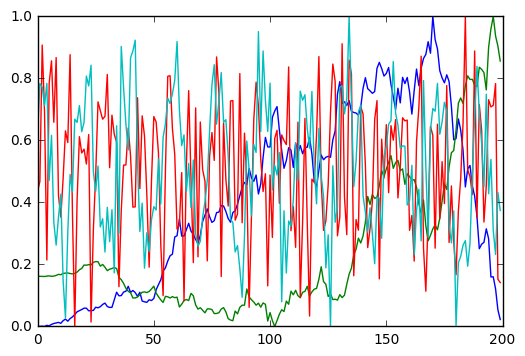